# MultiClass Methods for CNXDemo Age

In [6]:
################################################
# Python libraries & settings preamble
################################################
import binascii
from cycler import cycler
import datetime
from IPython.display import Image #Image(filename='//Users//161751//Desktop//Lion_Pride.jpg')
from IPython.display import display
import itertools
#import locale
#locale.setlocale(locale.LC_ALL, 'en_US')
import matplotlib
matplotlib.use('Agg')
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import numpy
import numpy.matlib
import os
import pandas
from pandas.tools.util import cartesian_product
from pg import DB
import plotly.plotly as py
py.sign_in('mathsmodel', 'zcwivinavl')
import plotly.graph_objs as go
import pylab
from pylab import rcParams
import re
import seaborn
import scipy
from scipy import stats
from scipy.interpolate import UnivariateSpline
from scipy.signal import argrelextrema
from scipy.spatial.distance import euclidean
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.lda import LDA
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF
import sys
import urllib
import time
import warnings
warnings.filterwarnings('ignore')
pylab.ion()


get_ipython().magic(u'matplotlib inline')
matplotlib.rcParams.update({'font.size': 10})
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)
matplotlib.rc('axes', labelsize='large')
matplotlib.rc('axes', titlesize='large')
rcParams['figure.figsize'] = 14, 6

def intWithCommas(x):
    if type(x) not in [type(0), type(0L)]:
        raise TypeError("Parameter must be an integer.")
    if x < 0:
        return '-' + intWithCommas(-x)
    result = ''
    while x >= 1000:
        x, r = divmod(x, 1000)
        result = ",%03d%s" % (r, result)
    return "%d%s" % (x, result)


# Read in Training, Validation, and OOS Sets

TOPIC: CNXDemo Age

ETS: merged

FEATURES: Hashed ~180,000 --> 256

In [7]:
#training = pandas.read_csv("mergedETS_training_featuresHashed.tsv", index_col=0, header=None)
#validation = pandas.read_csv("mergedETS_validation_featuresHashed.tsv", index_col=0, header=None)
ets = pandas.read_csv('mergedETS_featuresHashed.tsv', header=None, index_col=0)

t = pandas.read_csv('/home/cxt/spark/multinomial-uids/training.txt', header=None).as_matrix().ravel()
v = pandas.read_csv('/home/cxt/spark/multinomial-uids/validation.txt', header=None).as_matrix().ravel()
training = ets.loc[t].copy()
validation = ets.loc[v].copy()

training_labels = training[1]
training_features = training[training.columns[1:]]

validation_labels = validation[1]
validation_features = validation[validation.columns[1:]]
#del ets

how_wrong_can_we_classify_user = pandas.read_csv('how_wrong_can_we_classify_user.tsv').drop('Pred Bucket',axis=1)
#efficacy_validation = pandas.DataFrame(0, columns=['NBbernoulli','LDA','NBgaussian','NBmultinomial'], index=['accuracy','weighted-error'])

In [2]:
map_xid_tkid_age = pandas.DataFrame([[672,11349,21],
[673,11350,27],
[674,11351,32],
[675,11352,37],
[676,11353,42],
[677,11354,47],
[678,11355,52],
[679,11356,57],
[680,11357,62],
[681,11358,71]], columns=['tkid','xid','age']).set_index('xid')
oos = pandas.read_csv('oos_featuresHashed.tsv', header=None)
oos_labels = map_xid_tkid_age.loc[oos[0]]['tkid'].ravel()
oos_features = oos[oos.columns[1:]]

#efficacy_oos = pandas.DataFrame(0, columns=['NBbernoulli','LDA','NBgaussian','NBmultinomial'], index=['accuracy','weighted-error'])

In [7]:
oos.groupby(0).size() / float(oos.shape[0])

0
11349    0.067775
11350    0.079607
11351    0.093748
11352    0.090230
11353    0.087450
11354    0.094080
11355    0.108350
11356    0.105695
11357    0.105444
11358    0.167620
dtype: float64

### Method: Naive Bayes Bernoulli 

In [244]:
nb_bernoulli = BernoulliNB()
nb_bernoulli.fit(training_features, training_labels)

validation_pred = nb_bernoulli.predict(validation_features)
accuracy = nb_bernoulli.score(validation_features, validation_labels)
print(accuracy)

alg = "NBbernoulli"
uids = pandas.DataFrame(validation_labels, columns=['true']).join(pandas.DataFrame(validation_pred,columns=['pred'])) 
counts = uids.groupby(['true','pred']).size().unstack().transpose()
c = counts.reset_index(drop=True).transpose().reset_index(drop=True).transpose() 
distance_error_counts = how_wrong_can_we_classify_user.reset_index(drop=True).transpose().reset_index(drop=True).transpose().multiply(c)
distance_error = distance_error_counts.sum().sum()/counts.sum().sum()
efficacy_validation.loc['accuracy',alg] = accuracy
efficacy_validation.loc['weighted-error',alg] = distance_error

0.29323144738


### Method: Linear Discriminant Analysis

In [ ]:
lda = LDA()
lda.fit(training_features, training_labels)

validation_pred = lda.predict(validation_features)
accuracy = lda.score(validation_features,validation_labels)
print(accuracy)

alg = "LDA"
uids = pandas.DataFrame(validation_labels, columns=['true']).join(pandas.DataFrame(validation_pred,columns=['pred'])) 
counts = uids.groupby(['true','pred']).size().unstack().transpose()
c = counts.reset_index(drop=True).transpose().reset_index(drop=True).transpose() 
distance_error_counts = how_wrong_can_we_classify_user.reset_index(drop=True).transpose().reset_index(drop=True).transpose().multiply(c)
distance_error = distance_error_counts.sum().sum()/counts.sum().sum()
efficacy_validation.loc['accuracy',alg] = accuracy
efficacy_validation.loc['weighted-error',alg] = distance_error

# Principle Component Analysis

In [18]:
pca = PCA(n_components=training_features.shape[1])
pca.fit(training_features)
#plt.figure()
#plt.bar(numpy.arange(training_features.shape[1]), numpy.cumsum(pca.explained_variance_ratio_))
#plt.xlabel('Component')
#plt.ylabel('Explained Variance Ratio')

training_transformed = pca.transform(training_features)
validation_transformed = pca.transform(validation_features)

In [41]:
principle_components = pandas.DataFrame(pca.components_).transpose()
print(principle_components.shape)
principle_components.head()

(256, 256)


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.074278,0.088570,0.271287,-0.023725,-0.094105,-0.136623,-0.011198,-0.011292,0.024024,0.101774,...,-0.020795,-0.000482,0.008545,0.033718,0.002651,-0.009493,0.402715,-0.105636,-0.646764,-0.013882
1,-0.104350,0.133818,-0.129681,-0.080979,-0.057142,-0.110781,0.110550,0.055610,-0.018507,0.101492,...,0.002882,-0.002480,-0.020893,0.005431,0.004285,0.004494,0.018042,-0.012318,0.009280,0.003229
2,-0.071304,-0.048105,-0.037445,-0.064261,-0.048046,-0.027074,-0.090486,-0.006436,-0.050081,-0.032147,...,0.007272,0.000412,0.008902,-0.003136,0.001101,0.000272,-0.002041,0.008749,-0.001739,-0.008178
3,-0.064023,-0.080124,-0.022189,-0.023991,-0.007230,-0.022722,0.002701,-0.057324,-0.011524,0.024962,...,0.001392,0.002433,0.004055,-0.011253,-0.003600,-0.009001,0.005132,-0.010099,0.003127,0.003835
4,-0.099983,0.035365,-0.052276,-0.011954,0.034217,0.062766,0.007102,0.003635,-0.071361,-0.003909,...,-0.169632,0.289181,0.064872,0.125424,0.004668,-0.020019,-0.044315,0.011130,0.002360,0.001121


In [34]:
pca.components_ = pca.components_ * (-1)

In [42]:
print(pandas.DataFrame(training_transformed).shape)
pandas.DataFrame(training_transformed, index=training_features.index).head()

(275396, 256)


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,,,,,,,,,,,,,,,,,,,,,
20156320856149863,1.292196,-1.414736,-0.865697,-0.107149,0.095529,-0.815595,0.629699,0.449353,-1.597152,0.276497,...,0.047981,-0.007549,-0.059181,-0.130107,0.069376,-0.151251,0.146924,-0.115643,0.082727,-0.020595
16221703785943514,1.079409,-1.289207,0.032034,-1.404979,0.899182,0.179987,0.613738,0.332901,-0.189126,0.216958,...,0.105014,0.049927,-0.555613,0.373425,0.023921,-0.348361,-0.161817,-0.088779,-0.096491,0.047944
23184125582168755,0.640578,0.341507,-0.491820,1.393423,-0.119867,1.901982,-0.646612,-0.937447,-0.635041,0.267789,...,-0.216040,0.222657,0.007174,0.147877,0.065992,-0.058447,0.119141,0.012783,0.075637,0.044501
23272004138357351,-2.638846,0.579952,-0.874967,0.044859,-0.773818,0.255232,0.189929,-0.117071,-0.028746,0.327853,...,0.020204,-0.015949,0.005241,-0.000359,-0.022696,0.032951,-0.465394,0.145721,0.247518,0.004737
17804354130069208,-0.561183,0.543986,0.692097,-2.359414,0.444011,0.184647,-0.003125,-0.908948,0.440048,-1.233005,...,0.087059,-0.351251,-0.154111,-0.168031,0.012674,-0.223685,0.424829,-0.277871,-0.665473,-0.036420


In [43]:
print(pandas.DataFrame(validation_transformed).shape)
pandas.DataFrame(validation_transformed, index=validation_features.index).head()

(276164, 256)


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,,,,,,,,,,,,,,,,,,,,,
9288284844333351,3.849054,-0.147213,0.303542,-0.009842,-0.422465,-0.565225,0.177899,1.276933,-0.915168,-0.322446,...,-0.207194,0.209830,-0.613508,0.241852,0.102900,-0.404010,-0.098714,-0.001022,0.016137,-0.056288
20722957809749969,-2.708751,-0.105384,-0.097898,0.413972,-0.095751,-0.784123,0.144042,-0.368362,0.204037,-0.265425,...,0.053330,-0.030823,-0.047515,-0.056143,-0.009126,0.011423,-0.625218,0.143581,0.144589,0.025588
23207904112410946,-0.693783,-1.007255,-0.192161,0.811852,0.799170,-1.119624,0.680558,-0.121710,-1.010267,-0.364271,...,-0.090982,0.151331,0.030990,0.060757,0.000626,-0.056676,-0.116892,0.061647,-0.099041,-0.027580
8438939060540919,2.197646,-0.211044,-0.605976,-0.481092,-1.223206,0.322992,0.748968,0.807298,-0.134348,-0.530814,...,0.080648,-0.312088,-0.052590,-0.214522,-0.030994,0.004178,0.201142,0.901881,0.150124,0.038140
23051156318899201,-3.225811,0.381363,0.292191,0.663757,0.106623,-0.515320,-0.210134,-0.395549,-0.448635,0.656283,...,-0.003453,0.020852,-0.027991,-0.032445,-0.023354,0.015952,-0.299039,0.083732,0.590513,0.011559


### LDA (after PCA)

In [206]:
validation_pred = lda.predict(validation_transformed)
accuracy = lda.score(validation_transformed,validation_labels)
print(accuracy)

alg = "LDApca"
uids = pandas.DataFrame(validation_labels, columns=['true']).join(pandas.DataFrame(validation_pred,columns=['pred'])) 
counts = uids.groupby(['true','pred']).size().unstack().transpose()
c = counts.reset_index(drop=True).transpose().reset_index(drop=True).transpose() 
distance_error_counts = how_wrong_can_we_classify_user.reset_index(drop=True).transpose().reset_index(drop=True).transpose().multiply(c)
distance_error = distance_error_counts.sum().sum()/counts.sum().sum()
efficacy_validation.loc['accuracy',alg] = accuracy
efficacy_validation.loc['weighted-error',alg] = distance_error

0.114341141385


### Method: Naive Bayes Gaussian (after PCA)

In [150]:
nb_gaussian_pca = GaussianNB()
nb_gaussian_pca.fit(training_transformed, training_labels)

validation_pred = nb_gaussian_pca.predict(validation_transformed)
accuracy = nb_gaussian_pca.score(validation_transformed, validation_labels)

alg = "NBgaussian"
uids = pandas.DataFrame(validation_labels, columns=['true']).join(pandas.DataFrame(validation_pred,columns=['pred'])) 
counts = uids.groupby(['true','pred']).size().unstack().transpose()
c = counts.reset_index(drop=True).transpose().reset_index(drop=True).transpose() 
distance_error_counts = how_wrong_can_we_classify_user.reset_index(drop=True).transpose().reset_index(drop=True).transpose().multiply(c)
distance_error = distance_error_counts.sum().sum()/counts.sum().sum()
efficacy_validation.loc['accuracy',alg] = accuracy
efficacy_validation.loc['weighted-error',alg] = distance_error

### Method: Naive Bayes Multinomial (after PCA)

Map the real-valued (gaussian) components to positive-integer (multinomial) components, while maintaining their correct probabilities

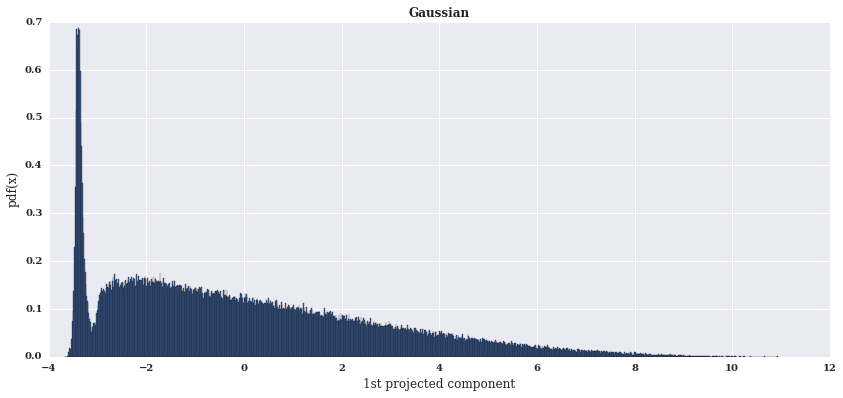

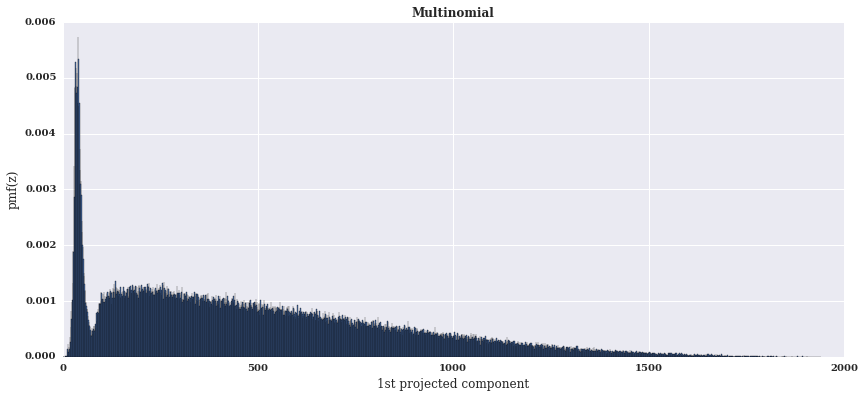

In [258]:
f = pandas.DataFrame(training_transformed)[0]
plt.hist(f, bins=1000, normed=True);
plt.xlabel('1st projected component')
plt.ylabel('pdf(x)')
plt.title('Gaussian')

gamma = 1000./numpy.var(f)
fmin = numpy.min(f)
z = numpy.floor((f-fmin)*gamma)
plt.figure()
plt.hist(z, bins=numpy.arange(numpy.max(z)), normed=True);
plt.xlabel('1st projected component')
plt.ylabel('pmf(z)')
plt.title('Multinomial')

In [38]:
training_z = pandas.DataFrame(training_transformed, index=training_features.index).apply(lambda x: numpy.floor((x-x.min())*(1000./x.var()))) 
validation_z = pandas.DataFrame(validation_transformed, index=validation_features.index).apply(lambda x: numpy.floor((x-x.min())*(1000./x.var()))) 

xmin = pandas.DataFrame(training_transformed).apply(lambda x: x.min())
print('Minimum value of each projected component sorted descending:')
display(xmin.sort_values(ascending=False)[:10])

xvar = pandas.DataFrame(training_transformed).apply(lambda x: x.var())
print('Variance of each projected component sorted descending:')
display(xvar.sort_values(ascending=False)[:10])

Minimum value of each projected component sorted descending:


255   -0.372968
253   -0.725135
251   -0.808249
252   -0.928738
254   -0.943782
248   -1.150766
235   -1.173624
246   -1.188375
249   -1.194732
236   -1.204279
dtype: float64

Variance of each projected component sorted descending:


0    7.546691
1    0.867504
2    0.635634
3    0.539353
4    0.507489
5    0.454196
6    0.421450
7    0.407392
8    0.364975
9    0.314452
dtype: float64

In [44]:
training_z.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,,,,,,,,,,,,,,,,,,,,,
20156320856149863,663.0,1710.0,2730.0,5112.0,5803.0,3938.0,8169.0,6796.0,2426.0,8243.0,...,24201.0,23875.0,22049.0,21789.0,27420.0,14257.0,24984.0,14282.0,31291.0,34593.0
16221703785943514,635.0,1855.0,4143.0,2705.0,7386.0,6130.0,8131.0,6511.0,6283.0,8053.0,...,25317.0,25013.0,12021.0,32095.0,26467.0,9980.0,17813.0,14912.0,25828.0,41321.0
23184125582168755,577.0,3735.0,3318.0,7894.0,5378.0,9922.0,5141.0,3392.0,5062.0,8215.0,...,19033.0,28433.0,23389.0,27479.0,27349.0,16271.0,24339.0,17292.0,31075.0,40983.0
23272004138357351,142.0,4010.0,2716.0,5393.0,4090.0,6296.0,7126.0,5406.0,6723.0,8406.0,...,23657.0,23709.0,23350.0,24445.0,25489.0,18255.0,10762.0,20407.0,36315.0,37080.0
17804354130069208,417.0,3968.0,5181.0,936.0,6489.0,6140.0,6668.0,3462.0,8007.0,3442.0,...,24966.0,17071.0,20131.0,21013.0,26231.0,12685.0,31439.0,10481.0,8483.0,33039.0


In [45]:
validation_z.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,,,,,,,,,,,,,,,,,,,,,
9288284844333351,1003.0,3170.0,4629.0,4852.0,4879.0,4501.0,7173.0,9062.0,5065.0,6663.0,...,20829.0,29957.0,10267.0,32161.0,23875.0,11274.0,20311.0,16611.0,30284.0,32940.0
20722957809749969,133.0,3219.0,3997.0,5636.0,5524.0,4019.0,7093.0,5009.0,8118.0,6843.0,...,25825.0,25259.0,21567.0,26184.0,21557.0,20224.0,8124.0,19956.0,34195.0,40838.0
23207904112410946,400.0,2180.0,3849.0,6373.0,7290.0,3279.0,8364.0,5616.0,4806.0,6530.0,...,23058.0,28815.0,23135.0,28529.0,21758.0,18757.0,19890.0,18061.0,26777.0,35709.0
8438939060540919,784.0,3097.0,3198.0,3980.0,3299.0,6460.0,8526.0,7905.0,7195.0,6002.0,...,26349.0,19767.0,21466.0,23008.0,21104.0,20068.0,27251.0,37493.0,34363.0,42049.0
23051156318899201,64.0,3779.0,4611.0,6099.0,5923.0,4611.0,6253.0,4942.0,6337.0,9766.0,...,24736.0,26267.0,21957.0,26660.0,21262.0,20322.0,15674.0,18572.0,47771.0,39485.0


In [358]:
nb_multinomial_pca = MultinomialNB()
nb_multinomial_pca.fit(training_z, training_labels)

validation_pred = nb_multinomial_pca.predict(validation_z)
accuracy = nb_multinomial_pca.score(validation_z, validation_labels)
print(accuracy)

alg = "NBmultinomial"
uids = pandas.DataFrame(validation_labels).rename(columns={1:'true'}).join( pandas.DataFrame(validation_pred, index=validation.index, columns=['pred']) ) 
counts = uids.groupby(['true','pred']).size().unstack().transpose()
c = counts.reset_index(drop=True).transpose().reset_index(drop=True).transpose() 
distance_error_counts = how_wrong_can_we_classify_user.reset_index(drop=True).transpose().reset_index(drop=True).transpose().multiply(c)
distance_error = distance_error_counts.sum().sum()/counts.sum().sum()
efficacy_validation.loc['accuracy',alg] = accuracy
efficacy_validation.loc['weighted-error',alg] = distance_error

0.475673874944


In [288]:
print("Validation class predictions:")
pandas.DataFrame(validation_pred, index=validation_features.index).head()

Validation class predictions:


,0
0,
15740002770882921,672
20076326138989514,672
13832899909391491,672
23061239623893428,672
19447249592914859,680


In [289]:
accuracy

0.46995621030652784

# Out-of-Sample

### Method: Naive Bayes Bernoulli (no PCA)

In [183]:
oos_pred = nb_bernoulli.predict(oos_features)
accuracy = nb_bernoulli.score(oos_features, oos_labels)
print(accuracy)

alg = "NBbernoulli"
uids = pandas.DataFrame(oos_labels, columns=['true']).join(pandas.DataFrame(oos_pred,columns=['pred'])) 
counts = uids.groupby(['true','pred']).size().unstack().transpose()
c = counts.reset_index(drop=True).transpose().reset_index(drop=True).transpose() 
distance_error_counts = how_wrong_can_we_classify_user.reset_index(drop=True).transpose().reset_index(drop=True).transpose().multiply(c)
distance_error = distance_error_counts.sum().sum()/counts.sum().sum()
efficacy_oos.loc['accuracy',alg] = accuracy
efficacy_oos.loc['weighted-error',alg] = distance_error

0.119727706385


### Method: Linear Discriminant Analysis (no PCA)

In [185]:
oos_pred = lda.predict(oos_features)
accuracy = lda.score(oos_features,oos_labels)
print(accuracy)

alg = "LDA"
uids = pandas.DataFrame(oos_labels, columns=['true']).join(pandas.DataFrame(oos_pred,columns=['pred'])) 
counts = uids.groupby(['true','pred']).size().unstack().transpose()
c = counts.reset_index(drop=True).transpose().reset_index(drop=True).transpose() 
distance_error_counts = how_wrong_can_we_classify_user.reset_index(drop=True).transpose().reset_index(drop=True).transpose().multiply(c)
distance_error = distance_error_counts.sum().sum()/counts.sum().sum()
efficacy_oos.loc['accuracy',alg] = accuracy
efficacy_oos.loc['weighted-error',alg] = distance_error

0.12776749792


### Method: Linear Discriminant Analysis (after PCA)

In [203]:
oos_pred = lda.predict(oos_transformed)
accuracy = lda.score(oos_transformed,oos_labels)
print(accuracy)

alg = "LDApca"
uids = pandas.DataFrame(oos_labels, columns=['true']).join(pandas.DataFrame(oos_pred,columns=['pred'])) 
counts = uids.groupby(['true','pred']).size().unstack().transpose()
c = counts.reset_index(drop=True).transpose().reset_index(drop=True).transpose() 
distance_error_counts = how_wrong_can_we_classify_user.reset_index(drop=True).transpose().reset_index(drop=True).transpose().multiply(c)
distance_error = distance_error_counts.sum().sum()/counts.sum().sum()
efficacy_oos.loc['accuracy',alg] = accuracy
efficacy_oos.loc['weighted-error',alg] = distance_error

0.0937070297248


### Method: Naive Bayes Gaussian (after PCA)

In [187]:
oos_transformed = pca.transform(oos_features)
oos_pred = lda.predict(oos_transformed)
accuracy = lda.score(oos_transformed,oos_labels)
print(accuracy)

alg = "NBgaussian"
uids = pandas.DataFrame(oos_labels, columns=['true']).join(pandas.DataFrame(oos_pred,columns=['pred'])) 
counts = uids.groupby(['true','pred']).size().unstack().transpose()
c = counts.reset_index(drop=True).transpose().reset_index(drop=True).transpose() 
distance_error_counts = how_wrong_can_we_classify_user.reset_index(drop=True).transpose().reset_index(drop=True).transpose().multiply(c)
distance_error = distance_error_counts.sum().sum()/counts.sum().sum()
efficacy_oos.loc['accuracy',alg] = accuracy
efficacy_oos.loc['weighted-error',alg] = distance_error

0.0937070297248


### Method: Naive Bayes Multinomial (after PCA)

In [189]:
oos_z = pandas.DataFrame(oos_transformed).apply(lambda x: numpy.floor((x-x.min())*(1000./x.var()))) 
oos_pred = nb_multinomial_pca.predict(oos_z)
accuracy = nb_multinomial_pca.score(oos_z, oos_labels)
print(accuracy)

alg = "NBmultinomial"
uids = pandas.DataFrame(oos_labels, columns=['true']).join(pandas.DataFrame(oos_pred,columns=['pred'])) 
counts = uids.groupby(['true','pred']).size().unstack().transpose()
c = counts.reset_index(drop=True).transpose().reset_index(drop=True).transpose() 
distance_error_counts = how_wrong_can_we_classify_user.reset_index(drop=True).transpose().reset_index(drop=True).transpose().multiply(c)
distance_error = distance_error_counts.sum().sum()/counts.sum().sum()
efficacy_oos.loc['accuracy',alg] = accuracy
efficacy_oos.loc['weighted-error',alg] = distance_error

0.0772132344204


# Efficacy Tables

In [207]:
print("efficacy_validation")
display(efficacy_validation)

print("efficacy_oos")
display(efficacy_oos)

efficacy_validation


,NBbernoulli,LDA,NBgaussian,NBmultinomial,LDApca
accuracy,0.290439,0.489363,0.262479,0.469088,0.114341
weighted-error,0.328481,0.196670,0.358640,0.202382,0.444431


efficacy_oos


,NBbernoulli,LDA,NBgaussian,NBmultinomial,LDApca
accuracy,0.119728,0.127767,0.093707,0.077213,0.093707
weighted-error,0.467571,0.450206,0.434996,0.693844,0.434996
